# Finding/opening ACCESS-OM3 `MC_25km_jra_ryf-1.0-beta` test run output using intake

This notebook demonstrates how to using intake-esm to find and load data data from the ACCESS-OM3 `MC_25km_jra_ryf-1.0-beta` test run.

For more information about using intake-esm to find and load data, see:
- the [intake-esm documentation](https://intake-esm.readthedocs.io/en/stable/)
- [this section](https://access-nri-intake-catalog.readthedocs.io/en/latest/usage/quickstart.html#using-an-intake-esm-datastore) of the access-nri-intake-catalog documentation

In [ ]:
#This cell must be in all notebooks!
#It allows us to run all the notebooks at once, this cell has a tag "parameters" which allows us to pass in 
# arguments externally using papermill (see mkfigs.sh for details)

### USER EDIT start
esm_file='/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json'
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.dpi']= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json
Plot folder path:  /g/data/tm70/as2285/access-om3-paper-figs


In [2]:
import xarray as xr
import cf_xarray
import intake
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from distributed import Client

In [3]:
client = Client(threads_per_worker=1)
print(client.dashboard_link)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43339 instead
  warnings.warn(


/proxy/43339/status


### Open the intake-esm datastore

In [4]:
#datastore_path = "/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json"
COLUMNS_WITH_ITERABLES = [
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
]

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=COLUMNS_WITH_ITERABLES
)


### What ocean variables are available at monthly frequency?

In [5]:
def available_variables(datastore):
    """Return a pandas dataframe summarising the variables in a datastore"""
    variable_columns = [col for col in datastore.df.columns if "variable" in col]
    return (
        datastore.df[variable_columns]
        .explode(variable_columns)
        .drop_duplicates()
        .set_index("variable")
        .sort_index()
    )

In [6]:
datastore_filtered = datastore.search(realm="ocean", frequency="1mon")

available_variables(datastore_filtered)

variable_long_name  \
variable                                                      
Heat_PmE     Heat flux into ocean from mass flux into ocean   
KE                       Layer kinetic energy per unit mass   
Rd_dx     Ratio between deformation radius and grid spacing   
SSH                                      Sea Surface Height   
SSU                              Sea Surface Zonal Velocity   
...                                                     ...   
yh                                 h point nominal latitude   
yq                                 q point nominal latitude   
z_l                                    Depth at cell center   
zi                              Interface pseudo-depth, -z*   
zl                                  Layer pseudo-depth, -z*   

         variable_standard_name                         variable_cell_methods  \
variable                                                                        
Heat_PmE                                 area:mean yh:mean xh:mean time: mean   
KE                               area:mean zl:mean yh:mean xh:mean time: mean   
Rd_dx                                    area:mean yh:mean xh:mean time: mean   
SSH                                      area:mean yh:mean xh:mean time: mean   
SSU                                               yh:mean xq:point time: mean   
...                         ...                                           ...   
yh                                                                              
yq                                                                              
z_l                                                                             
zi                                                                              
zl                                                                              

         variable_units  
variable                 
Heat_PmE          W m-2  
KE               m2 s-2  
Rd_dx             m m-1  
SSH                   m  
SSU               m s-1  
...                 ...  
yh        degrees_north  
yq        degrees_north  
z_l              meters  
zi                meter  
zl                meter  

[98 rows x 4 columns]

### Load monthly sea surface height (`zos`) and plot the field at the last available time

In [7]:
zos = datastore.search(variable="SSH", frequency="1mon").to_dask(
    xarray_open_kwargs = dict(
        chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


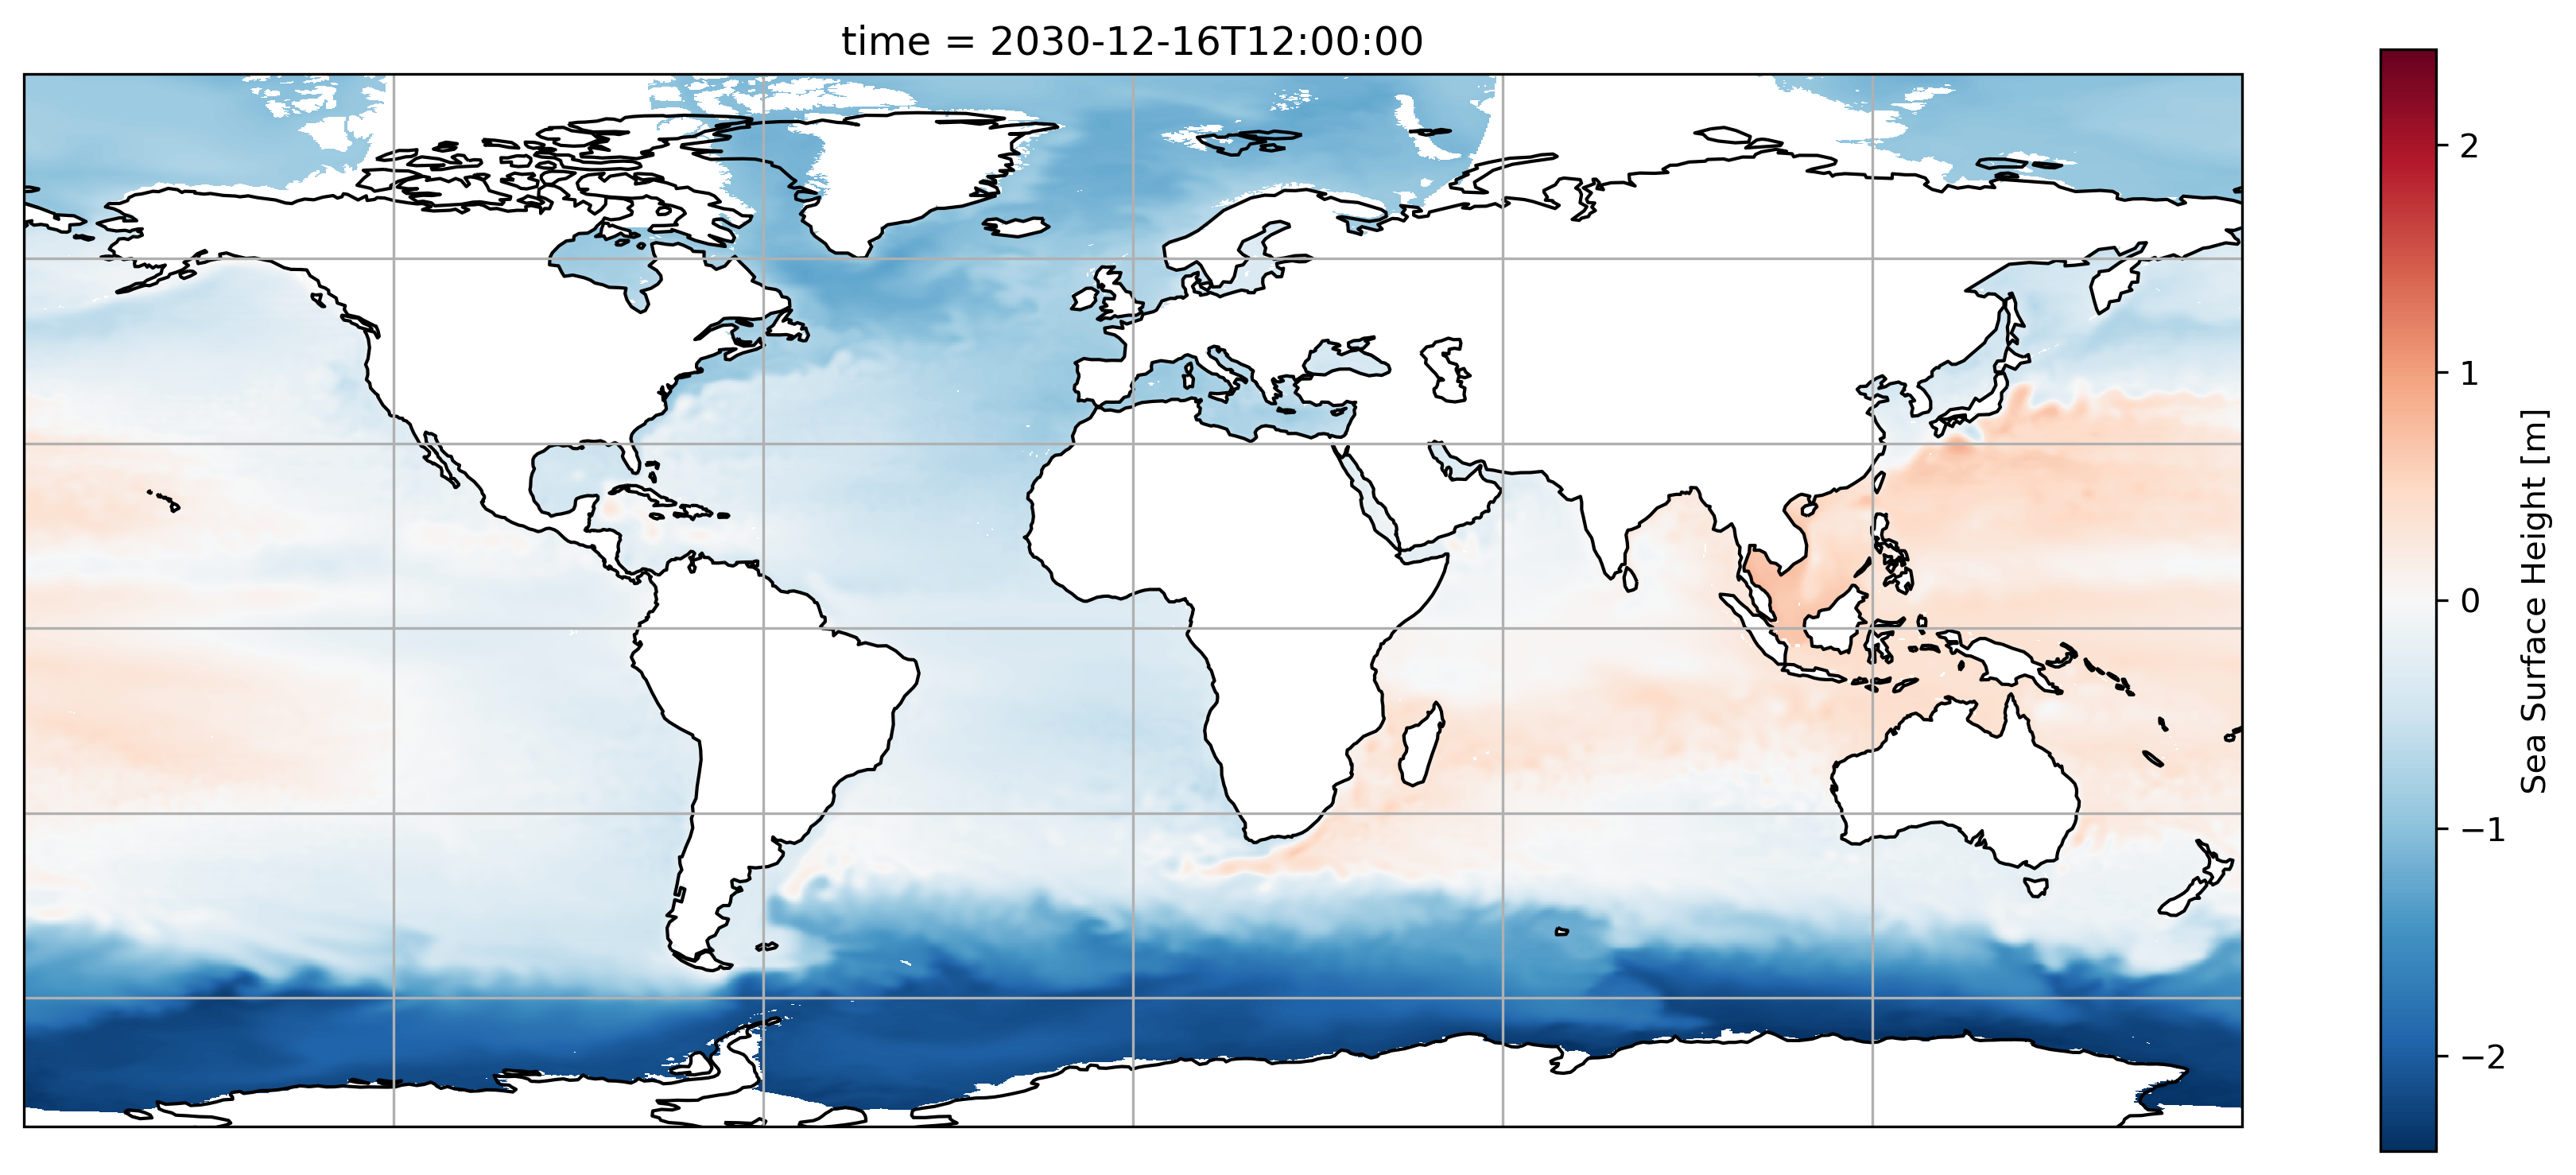

In [8]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(15,6), subplot_kw=dict(projection=proj))

zos["SSH"].isel(time=-1).plot(ax=ax)
ax.coastlines()
_ = ax.gridlines()

#### Fixing the plot axes

Notice that the white land-masked regions are distorted away from the coastlines in the Arctic in the above plot. This is because a tripolar grid is used, so the grid lines are not zonal and meridional north of 65N, and consequently the nominal 1D coordinates `xh` and `yh` are incorrect. To fix this we need to use 2d coordinates `geolon` and `geolat`. We get these from a separate file which was generated without processor masking, avoiding regions on NaNs in the continents.


In [9]:
# get coords from short run without processor masking
# https://github.com/aekiss/MOM6-CICE6/commit/59ed8ffc6ae1d4a79821a951924e7c853d9b788a
# https://xgcm.readthedocs.io/en/latest/xgcm-examples/03_MOM6.html#A-note-on-geographical-coordinates
static = xr.open_dataset("/g/data/ik11/outputs/access-om3-025/grid/access-om3.mom6.static.nc")

Now try that plot again, this time using `.cf.assign_coords` to assign `geolon` and `geolat`.

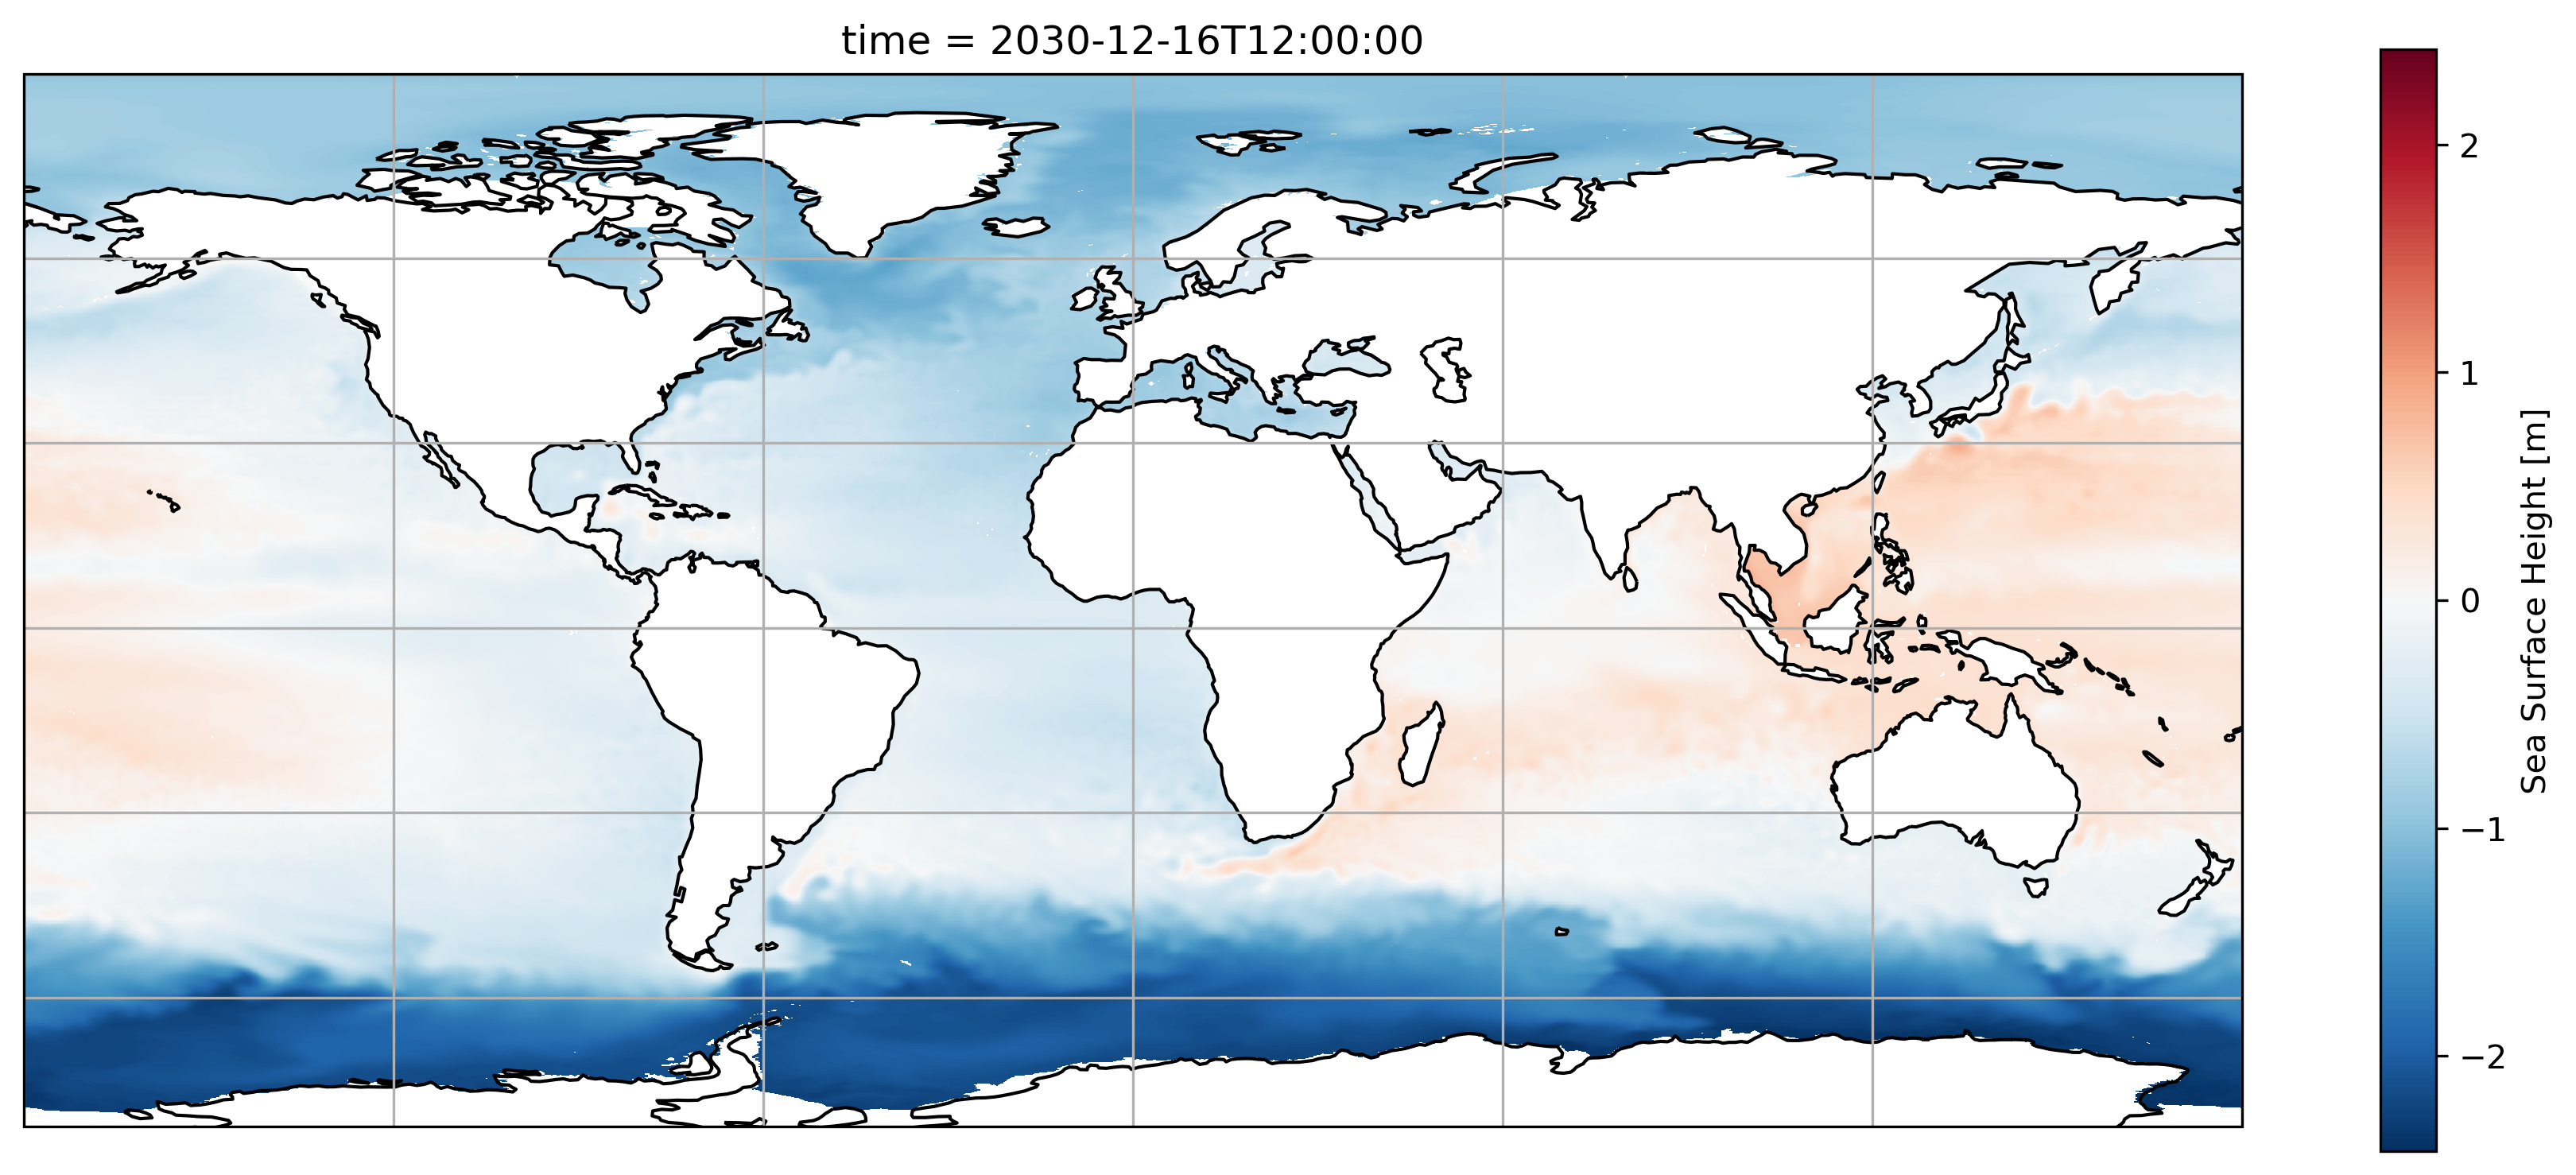

In [10]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(15,6), subplot_kw=dict(projection=proj))

zos["SSH"].isel(time=-1).cf.assign_coords( { "longitude": static["geolon"],
                                              "latitude": static["geolat"] }).plot(ax=ax)
ax.coastlines()
_ = ax.gridlines()
plt.savefig(plotfolder+'exampleout.png')

In [11]:
client.close()